In [1]:
from pettingzoo.classic import connect_four_v3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [ ]:
# The agents are loacted in the dqn_utils file 

# Running a game


The following function runs a full game between the two agents. 

In [47]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

In [48]:
# agent0 = RandomPlayer()
# agent1 = PlayLeftmostLegal()

# play_game(env, agent0, agent1, display=True)

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [49]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [50]:
def eval_against_policy(env, agent, policy, n_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(n_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

# Training an agent 

In [137]:
def train_player_0(env, player_0, player_1, n_episodes, first_player = True, eval_every=50, reward_threshold=0.9, early_stopping_insistance=3):
    
    if first_player : 
        agents = [player_0, player_1]
    else : 
        agents = [player_1, player_0]
    losses = []
    all_rewards = []
    episodes_length = []
    
    for ep in tqdm(range(n_episodes), desc="Train"):
        done = False
        state = env.reset()
        length_episode = 0
        while not done:
            length_episode += 1
            for agent in agents:
                next_state, reward, terminated, truncated, info = env.last()
                done = terminated or truncated
                if done:
                    break 
                else:
                    action = agent.get_action(next_state)
                    env.step(action)
                    if agent == player_0 :
                        loss_val = agent.update(state, action, reward, terminated, next_state)
                        if loss_val is not None : 
                            losses.append(loss_val)
                        state = next_state   
        
        episodes_length.append(length_episode)
        
        if ep%eval_every == 0:
            print("[Train] Evaluating the DQN Agent.")
            rewards = eval_against_policy(env, player_0, player_1, n_episodes=30, first_player=first_player)
            all_rewards.append(np.mean(rewards))
            print(f"Mean reward is: {np.mean(rewards)}")
            # early stopping
            if np.mean(rewards) >= reward_threshold:
                # the threshold needs to be reached several time for the training to stop
                early_stopping_insistance -= 1
                if early_stopping_insistance == 0  : 
                    break
            
                
    return losses, all_rewards, episodes_length

# Some training experiments

### DQN Agent vs Random Agent, DQN agent playing first

In [138]:
import dqn_utils
import importlib
importlib.reload(dqn_utils)  # to reload easily when I modify the agent's code :)

<module 'dqn_utils' from '/Users/sachamuller/Documents/Scolaire/5-CentraleSupelec/3A/7-SM11/RL/connect4/dqn_utils.py'>

In [139]:
gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-1

DQN_agent = dqn_utils.DQN_Skeleton(
        action_space_size=7, # number of columns
        observation_space_size = 6*7,  # nb_rows, nb_columns
        gamma=gamma,
        batch_size=batch_size,
        buffer_capacity=buffer_capacity,
        update_target_every=update_target_every,
        epsilon_start=epsilon_start,
        decrease_epsilon_factor=decrease_epsilon_factor,
        epsilon_min=epsilon_min,
        learning_rate=learning_rate,
        env=env,
    )

random_agent = dqn_utils.RandomAgent()

In [140]:
eval_before_training = eval_against_policy(env, DQN_agent, random_agent, n_episodes=1000, first_player=True)

In [141]:
losses, all_rewards, episodes_length = train_player_0(env, DQN_agent, random_agent, 1000)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/sachamuller/Documents/Scolaire/5-CentraleSupelec/3A/7-SM11/RL/connect4/dqn_utils.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor([reward]),
/Users/sachamuller/Documents/Scolaire/5-CentraleSupelec/3A/7-SM11/RL/connect4/dqn_utils.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[Train] Evaluating the DQN Agent.


Train:   1%|          | 9/1000 [00:00<00:40, 24.58it/s]

Mean reward is: 0.3333333333333333


Train:   5%|▌         | 50/1000 [00:02<00:39, 23.96it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.7333333333333333


Train:  10%|▉         | 99/1000 [00:04<00:45, 19.94it/s]

[Train] Evaluating the DQN Agent.


Train:  10%|█         | 105/1000 [00:05<01:01, 14.66it/s]

Mean reward is: 0.4


Train:  15%|█▌        | 151/1000 [00:07<01:04, 13.22it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.6666666666666666


Train:  20%|██        | 200/1000 [00:10<00:36, 21.94it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.6


Train:  25%|██▌       | 251/1000 [00:13<00:49, 15.23it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.6666666666666666


Train:  30%|███       | 300/1000 [00:15<00:27, 25.39it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.4


Train:  35%|███▍      | 349/1000 [00:17<00:34, 19.11it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.6666666666666666


Train:  40%|████      | 401/1000 [00:20<00:30, 19.66it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.9333333333333333


Train:  45%|████▍     | 449/1000 [00:22<00:24, 22.28it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.8


Train:  50%|████▉     | 499/1000 [00:24<00:19, 25.56it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.8666666666666667


Train:  55%|█████▌    | 550/1000 [00:27<00:21, 20.48it/s]

[Train] Evaluating the DQN Agent.


Train:  55%|█████▌    | 553/1000 [00:27<00:30, 14.74it/s]

Mean reward is: 0.8666666666666667


Train:  60%|█████▉    | 599/1000 [00:29<00:19, 20.44it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.8


Train:  65%|██████▌   | 650/1000 [00:32<00:19, 18.42it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.7333333333333333


Train:  70%|███████   | 700/1000 [00:35<00:13, 21.56it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.7333333333333333


Train:  75%|███████▌  | 751/1000 [00:37<00:12, 19.40it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.9333333333333333


Train:  80%|████████  | 800/1000 [00:39<00:09, 20.87it/s]

[Train] Evaluating the DQN Agent.
Mean reward is: 0.8666666666666667


Train:  85%|████████▌ | 850/1000 [00:41<00:04, 30.34it/s]

[Train] Evaluating the DQN Agent.


Train:  85%|████████▌ | 854/1000 [00:42<00:09, 15.97it/s]

Mean reward is: 0.8


Train:  90%|████████▉ | 898/1000 [00:44<00:04, 24.08it/s]

[Train] Evaluating the DQN Agent.


Train:  90%|█████████ | 904/1000 [00:44<00:05, 18.53it/s]

Mean reward is: 0.6


Train:  92%|█████████▏| 921/1000 [00:45<00:03, 22.97it/s]

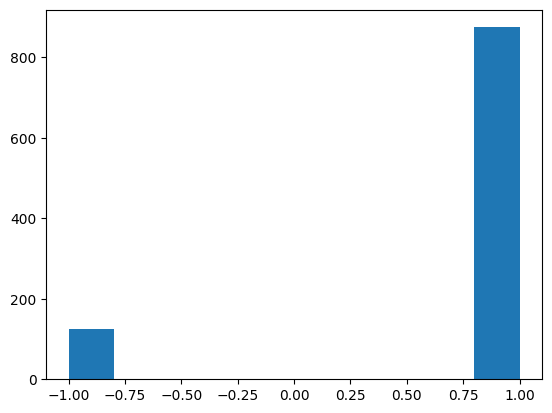

In [ ]:
eval_after_training = eval_against_policy(env, DQN_agent, dqn_utils.RandomAgent(), n_episodes=1000, first_player=True)

In [ ]:
def training_dashboard(eval_before_training, eval_after_training, losses, all_rewards, episodes_length):
    fig = plt.figure(constrained_layout=True)
    gs0 = fig.add_gridspec(nrows=2, ncols=1)

    gs00 = gs0[0].subgridspec(1, 2)
    gs01 = gs0[1].subgridspec(1, 3)

    ax1 = fig.add_subplot(gs00[0:1])
    ax1.hist(eval_before_training)
    ax2 = fig.add_subplot(gs00[1:2])
    ax2.hist(eval_after_training)
    ax3 = fig.add_subplot(gs01[0:1])
    ax3.plot(losses)
    ax4 = fig.add_subplot(gs01[1:2])
    ax4.plot(all_rewards)
    ax5 = fig.add_subplot(gs01[2:3])
    ax5.plot(episodes_length)

    plt.show()

training_dashboard(eval_before_training, eval_after_training, losses, all_rewards, episodes_length)

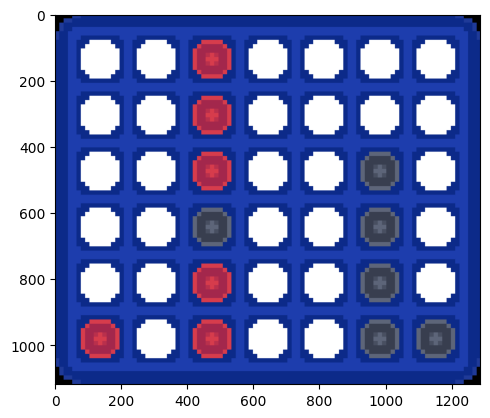

Player 1: Random Agent won
[[ 0  0 -1  0  0  0  0]
 [ 0  0 -1  0  0  0  0]
 [ 0  0 -1  0  0  1  0]
 [ 0  0  1  0  0  1  0]
 [ 0  0 -1  0  0  1  0]
 [-1  0 -1  0  0  1  1]]


1

In [ ]:
play_game(env, DQN_agent, dqn_utils.RandomAgent(), display=True)